In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import seaborn as sb

from Bio import SeqIO

sb.set()
pd.set_option("display.max_rows", None)

# Evaluation of DADA2 on Franzén data

The following notebook describes the steps and results of the evaluation.

In [ ]:
# Initial files and directories:
#
# dada2_franzen
# |- data # will contain the in-silico sequenced data sets
# |
# |- evaluation # will contain the evaluation plots and tables
# |
# |- outputs # will contain the cluster and metric outputs
# |
# \- 40168_2015_105_MOESM9_ESM.csv  # CSV version of Additional file 9 of Franzén et al. (see below)

## Analysis workflow

The data sets are prepared as described in Franzén et al., *Improved OTU-picking using long-read 16S rRNA gene amplicon sequencing and generic hierarchical clustering* (https://doi.org/10.1186/s40168-015-0105-6),
except that there are no Ns between the forward and reverse portion of the reads.

The taxonomic assignment is obtained from the known sources during the creation of the mock communities (simulated sequencing).

The DADA2 pipeline is executed as in Callahan et al., DADA2: High-resolution sample inference from Illumina amplicon data (https://doi.org/10.1038/nmeth.3869; dereplication -- DADA2 -- chimera detection -- output sample sequences) and, in addition,
we reconstruct the OTUs corresponding to the sample sequences (both with and without chimera filtering).

## Commands

The following commands prepare and cluster the data sets. The results are evaluated below.

In order to execute the workflow as provided here, the `tools` subdirectory of the overall repository has to contain the binaries of Infernal (cmbuild, cmalign) and ART (art_illumina),
but the paths can be adjusted.   

IMPORTANT: The commands are not intended to be executed from this notebook. They should be executed from the root directory of the overall repository.

In [ ]:
%%bash

TOOLS_DIR=tools
ANALYSIS_DIR=analyses/dada2_franzen
DATA_DIR=${ANALYSIS_DIR}/data
OUTPUT_DIR=${ANALYSIS_DIR}/outputs

# prepare tools and reference data
CMBUILD_PATH=${TOOLS_DIR}/infernal-1.1.2-linux-intel-gcc/binaries/cmbuild # adjust to your system
python -m scripts.analyses.analysis_franzen prepare ${DATA_DIR} --cmbuild ${CMBUILD_PATH}

# create list files of mock communities
python -m scripts.analyses.analysis_franzen lists ${ANALYSIS_DIR}/40168_2015_105_MOESM9_ESM.csv ${DATA_DIR}/list_files

# create mock communities
GG_DB=${DATA_DIR}/gg_13_5.fasta
MOCK_LIST=${DATA_DIR}/list_files/list.txt
MSA_MODEL=${DATA_DIR}/bacteria16S_508_mod5.cmfile
CMALIGN_PATH=${TOOLS_DIR}/infernal-1.1.2-linux-intel-gcc/binaries/cmalign # adjust to your system
ART_PATH=${TOOLS_DIR}/art_bin_VanillaIceCream/art_illumina # adjust to your system
python -m scripts.analyses.analysis_franzen mock ${GG_DB} ${MOCK_LIST} ${MSA_MODEL} ${DATA_DIR} --cmalign ${CMALIGN_PATH} --art ${ART_PATH} --miseq --skip_ambiguous --num_n 0

# run DADA2 and determine clustering quality
DATA=( "LC" "MC" "HC" )
REGIONS=( "V3-V4" "V4" )
for D in "${DATA[@]}"; do
  for ((I=1; I<=10; I++)); do
    for R in "${REGIONS[@]}"; do
      echo ${D}_${I}_${R}
      READS=${DATA_DIR}/${D}_${I}/${D}_${I}_${R}_miseq_rs.fastq
      TAX=franzen:${DATA_DIR}/${D}_${I}/${D}_${I}_${R}_miseq_rs.tax
      python -m scripts.analyses.analysis_franzen run_dada2 ${D}_${I}_${R} ${READS} ${OUTPUT_DIR}/${D}_${I}_${R} --tax_files ${TAX}
    done
  done
done

## Evaluation

**Configuration**

In [2]:
data_sets = ['LC', 'MC', 'HC']
num_samples = 10
regions = ['V3-V4', 'V4']
ground_truths = ['franzen']

opts = ['dada2', 'dada2_nc']

data_dir = 'data'
results_dir = 'outputs'
eval_dir = 'evaluation'

### Number of clusters and amplicons

Reads the input files and the cluster outputs for all data sets and compares the number of clusters and amplicons.

In [3]:
# Requires the input and OTU files. Alternatively, the evaluation can use the stored information (see below).
df_columns = ['data_set', 'tool', 'mode', 'refinement', 'threshold', 'num_input_amplicons', 'input_mass', 'num_clusters', 'num_output_amplicons', 'output_mass', 'ds', 'rt']

rows = []

for ds in data_sets:
    for rt in regions:
        for s in range(1, num_samples + 1):
            run_name = '%s_%i_%s' % (ds, s, rt)

            seq_file = '%s/%s_%i/%s_miseq_rs.fastq' % (data_dir, ds, s, run_name) # the input sequences
            num_input_amplicons = 0
            input_mass = 0
            with open(seq_file, 'r') as in_file:
                for record in SeqIO.parse(in_file, 'fastq'):
                    num_input_amplicons += 1
                    input_mass += int(record.id.split('_')[-1]) if ('_' in record.id) else 1

            for opt in opts:
                otu_file = '%s/%s/%s_%s_otus.txt' % (results_dir, run_name, run_name, opt)

                num_output_amplicons = 0
                num_clusters = 0
                output_mass = 0
                with open(otu_file, 'r') as in_file:
                    for line in in_file:
                        num_output_amplicons += len(line.strip().split(' '))
                        num_clusters += 1
                        output_mass += sum([int(m.split('_')[-1]) for m in line.strip().split(' ')])

                tool = 'dada2'
                mode = 'non-chimeric' if 'nc' in opt else 'chimeric'
                refinement = 'nf'
                threshold = 0.0

                rows.append([run_name, tool, mode, refinement, threshold, num_input_amplicons, input_mass, num_clusters, num_output_amplicons, output_mass, ds, rt])

df_counts = pd.DataFrame(rows, columns = df_columns)

*Column descriptions:*   
`num_input_amplicons`: The number of entries in the corresponding input file.   
`input_mass`: The sum of the abundances of all entries in the input file.   
`num_clusters`: The number of reconstructed clusters corresponding to the sample sequences determined by DADA2.   
`num_output_amplicons`: The number of amplicons contained in the reconstructed clusters.   
`output_mass`: The sum of the abundances of all amplicons contained in the reconstructed clusters.   

In [4]:
df_counts[['data_set', 'mode', 'num_input_amplicons', 'input_mass', 'num_clusters', 'num_output_amplicons', 'output_mass']]

,data_set,mode,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass
0,LC_1_V3-V4,chimeric,1980,1980,1,20,20
1,LC_1_V3-V4,non-chimeric,1980,1980,1,20,20
2,LC_2_V3-V4,chimeric,1980,1980,1,20,20
3,LC_2_V3-V4,non-chimeric,1980,1980,1,20,20
4,LC_3_V3-V4,chimeric,2000,2000,1,20,20
5,LC_3_V3-V4,non-chimeric,2000,2000,1,20,20
6,LC_4_V3-V4,chimeric,2000,2000,1,20,20
7,LC_4_V3-V4,non-chimeric,2000,2000,1,20,20
8,LC_5_V3-V4,chimeric,1980,1980,1,20,20
9,LC_5_V3-V4,non-chimeric,1980,1980,1,20,20


In [5]:
df_counts.to_csv('%s/df_counts.csv' % eval_dir, sep = ';', index = False)
#df_counts = pd.read_csv('%s/df_counts.csv' % eval_dir, sep = ';')

Graphical representation of the cluster and amplicon counts:

In [6]:
df_counts_V34 = df_counts.loc[df_counts['rt'] == 'V3-V4'].copy()
df_counts_V4 = df_counts.loc[df_counts['rt'] == 'V4'].copy()

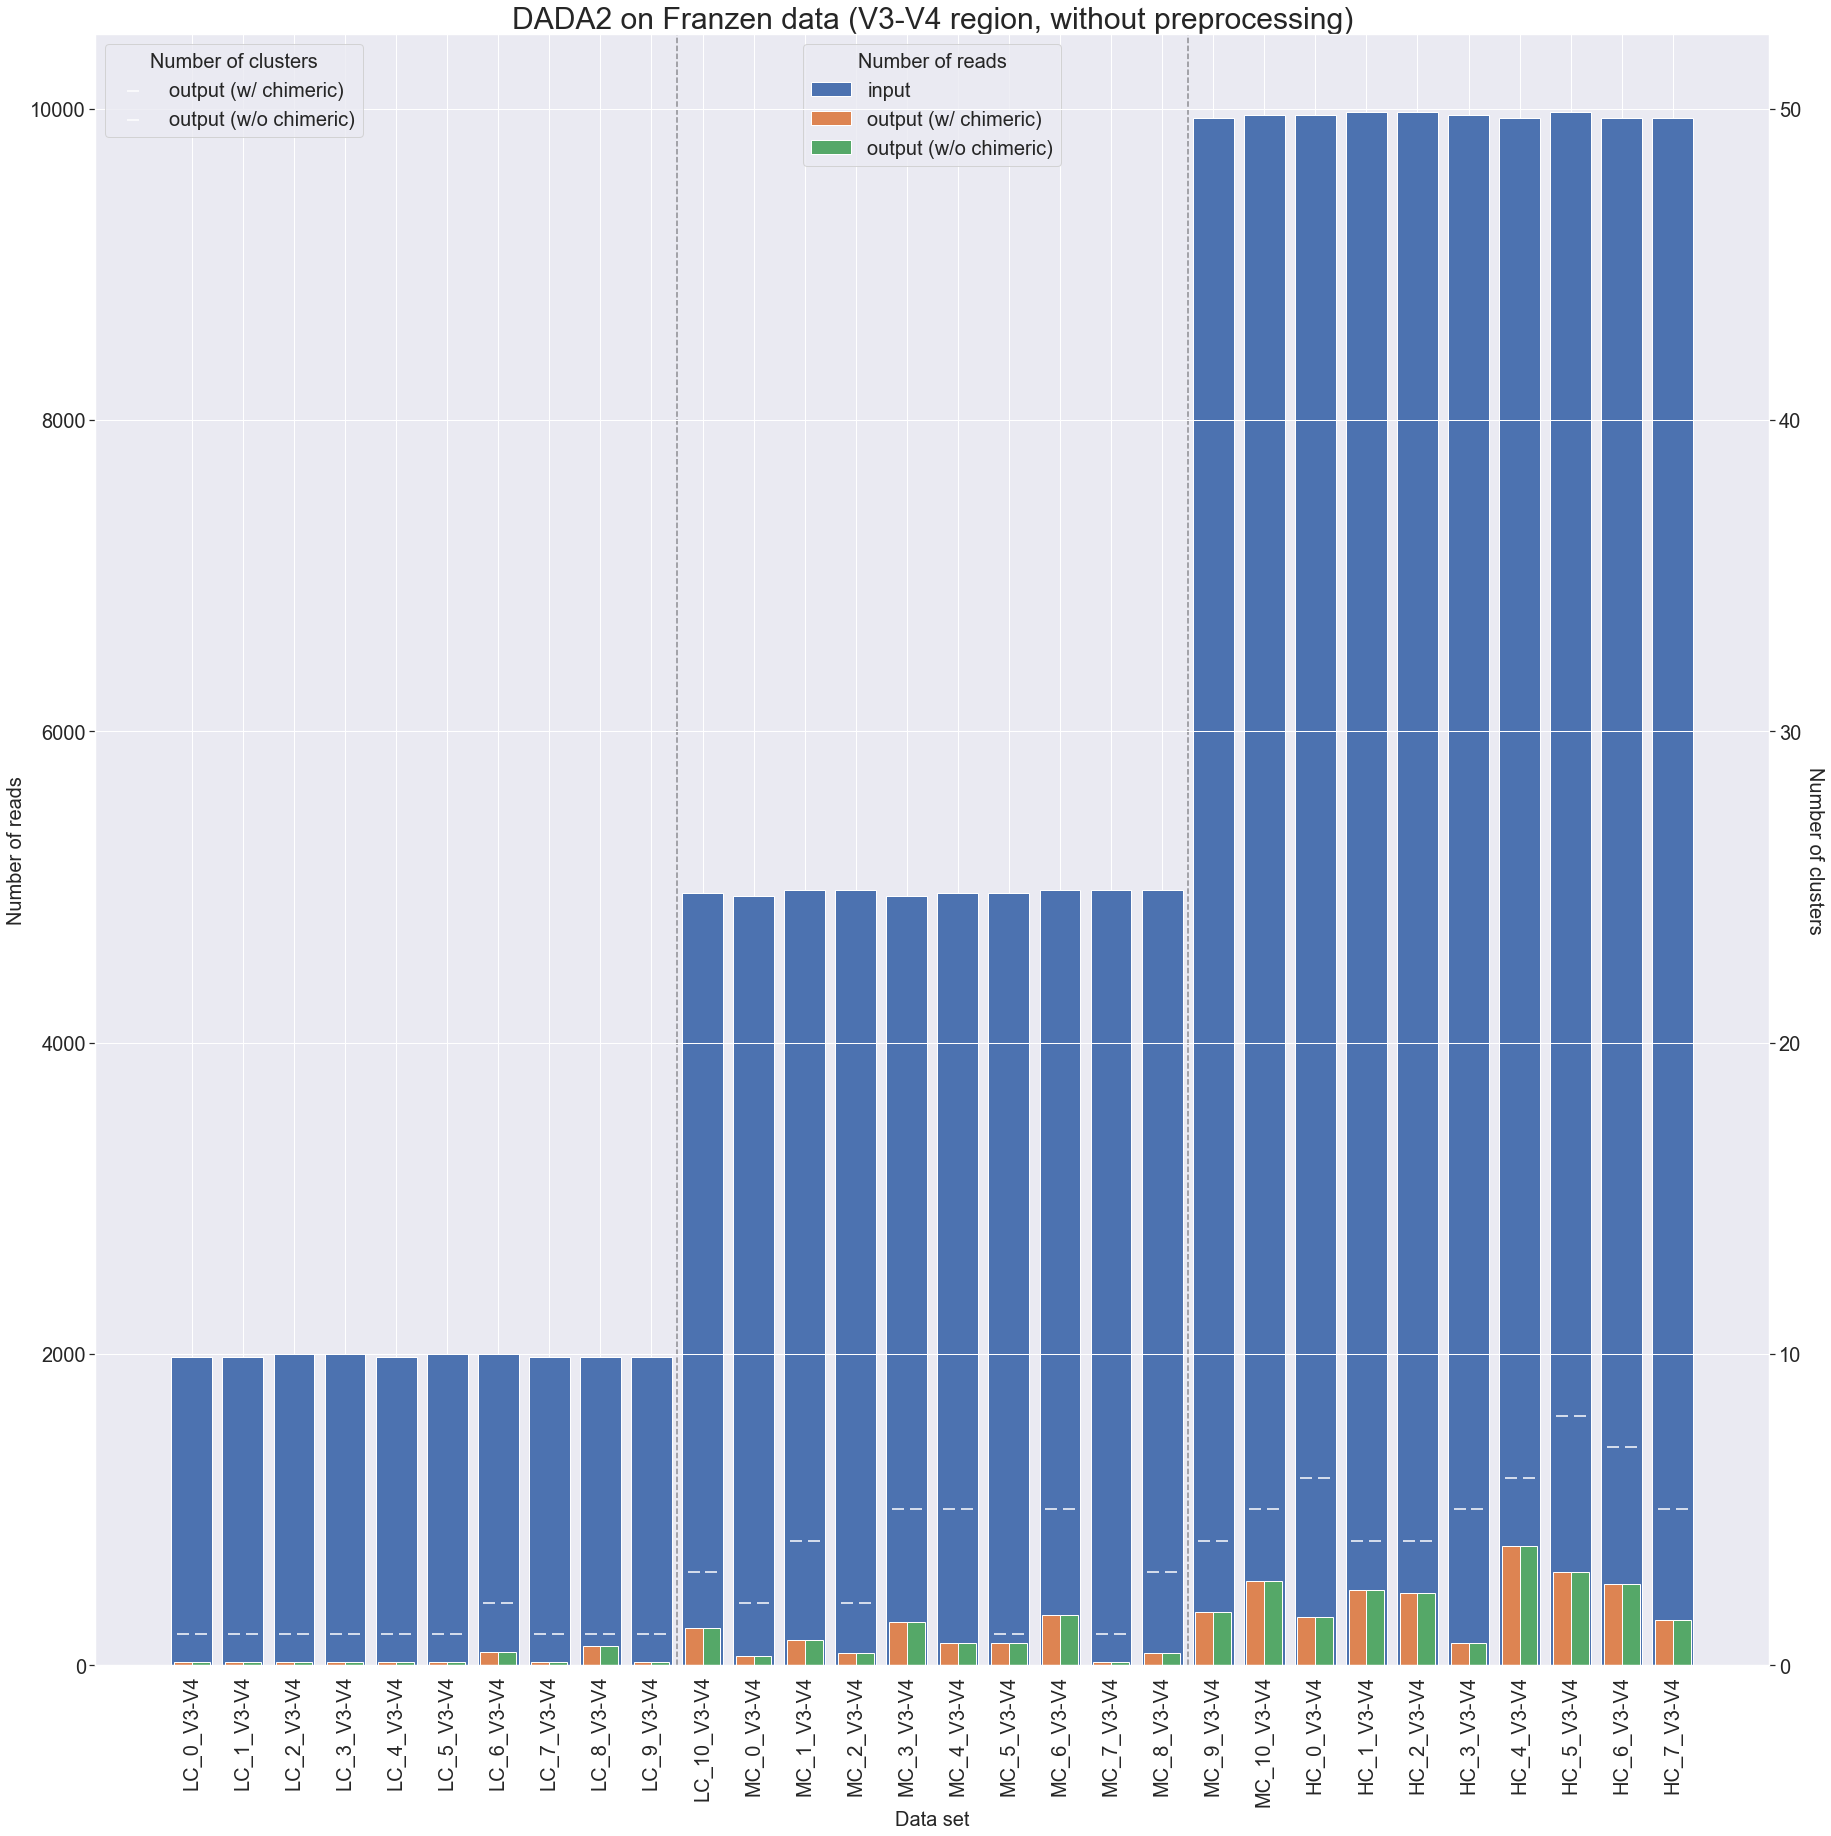

In [7]:
fig, ax = plt.subplots(figsize = (30, 30))
pos = range(0, len(df_counts_V34['data_set'].unique())) 

df_c = df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']
df_nc = df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']

ax.bar(pos, df_c['num_input_amplicons'], label = 'input')
ax.bar([p - 0.175 for p in pos], df_c['num_output_amplicons'], width = 0.35, label = 'output (w/ chimeric)')
ax.bar([p + 0.175 for p in pos], df_nc['num_output_amplicons'], width = 0.35, label = 'output (w/o chimeric)')
ax.set_xlabel('Data set', fontsize = 20)
ax.set_xticks(pos)
ax.set_xticklabels(['%s_%i_V3-V4' % (ds, i) for ds in data_sets for i in range(0, num_samples + 1)], rotation = 90)
ax.set_ylabel('Number of reads', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)

ax.axvline(9.5, color = 'black', linestyle = 'dashed', alpha = 0.4)
ax.axvline(19.5, color = 'black', linestyle = 'dashed', alpha = 0.4)

ax2 = ax.twinx()
ax2.plot([0],[0])
ax2.scatter([p - 0.175 for p in pos], list(df_c['num_clusters']), label = 'output (w/ chimeric)', 
            marker = '_', s = 150, color = 'w')
ax2.scatter([p + 0.175 for p in pos], list(df_nc['num_clusters']), label = 'output (w/o chimeric)',
            marker = '_', s = 150, color = 'w')

ax2.set_ylabel('Number of clusters', rotation = 270, va = 'bottom', fontsize = 20)
ax2.tick_params(axis = 'y', labelsize = 20)

leg = ax.legend(fontsize = 20, loc = 9)
leg.set_title('Number of reads', prop = {'size': 20})

leg2 = ax2.legend(fontsize = 20, loc = 2)
leg2.set_title('Number of clusters', prop = {'size': 20})

ax2.set_ylim((ax.get_ylim()[0] / 200, ax.get_ylim()[1] / 200));
ax.set_title('DADA2 on Franzen data (V3-V4 region, without preprocessing)', fontsize = 30);

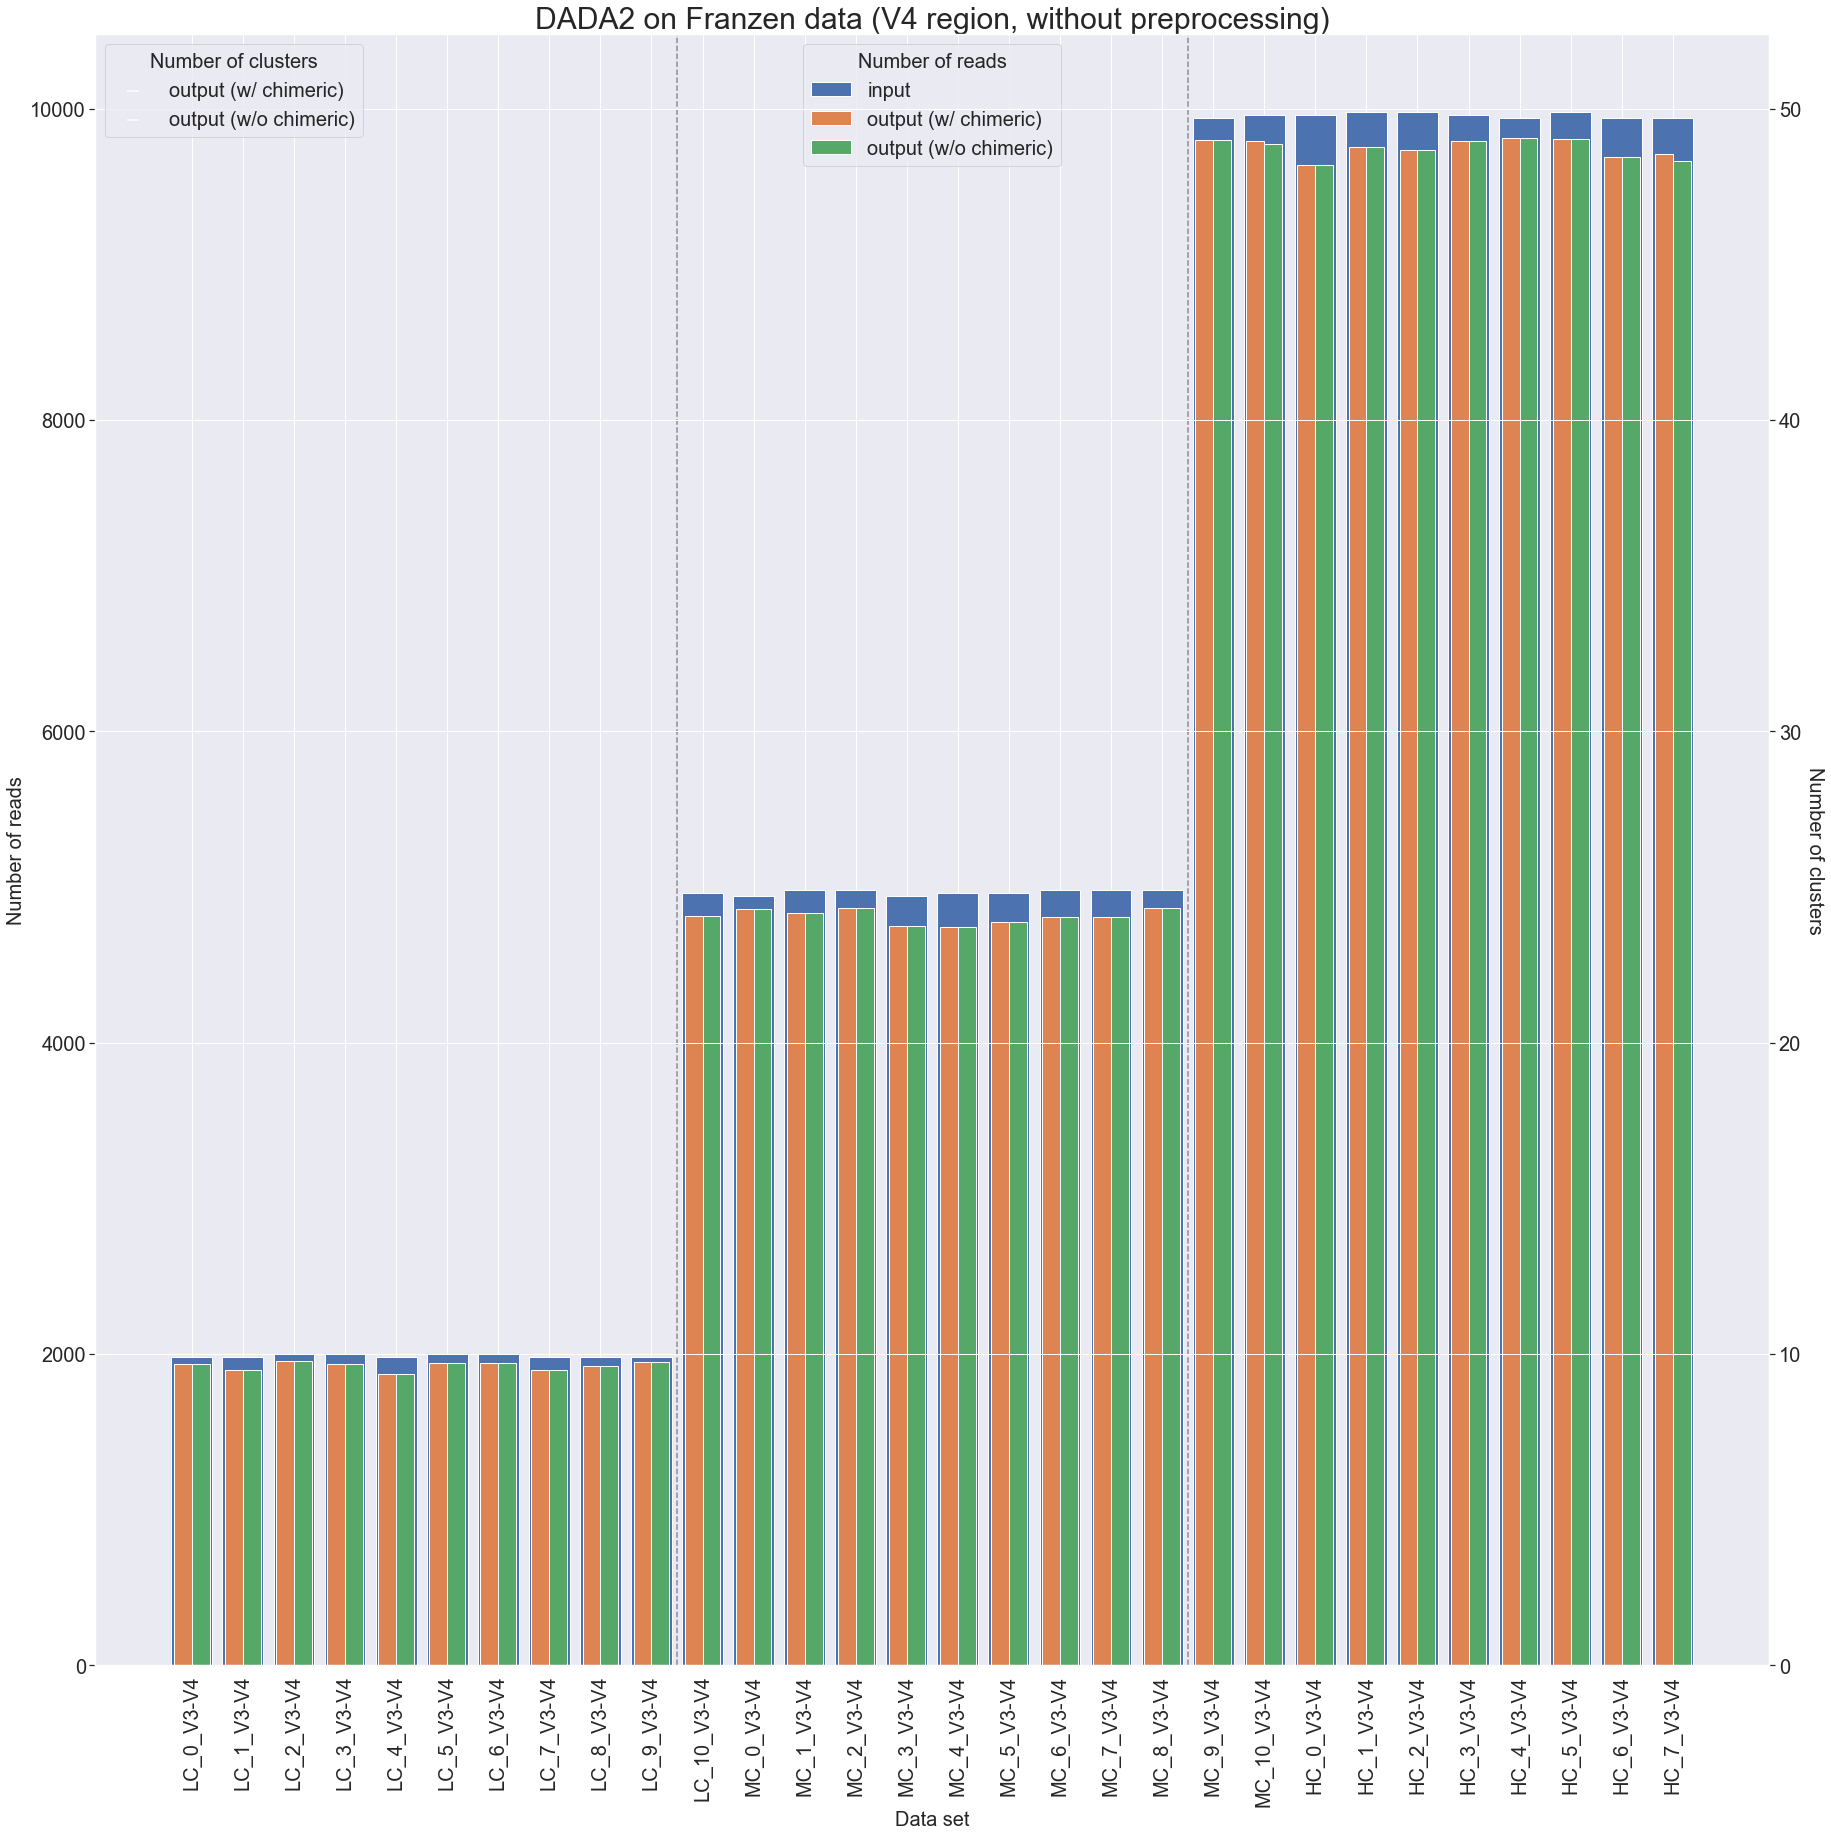

In [8]:
fig, ax = plt.subplots(figsize = (30, 30))
pos = range(0, len(df_counts_V4['data_set'].unique())) 

df_c = df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']
df_nc = df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']

ax.bar(pos, df_c['num_input_amplicons'], label = 'input')
ax.bar([p - 0.175 for p in pos], df_c['num_output_amplicons'], width = 0.35, label = 'output (w/ chimeric)')
ax.bar([p + 0.175 for p in pos], df_nc['num_output_amplicons'], width = 0.35, label = 'output (w/o chimeric)')
ax.set_xlabel('Data set', fontsize = 20)
ax.set_xticks(pos)
ax.set_xticklabels(['%s_%i_V3-V4' % (ds, i) for ds in data_sets for i in range(0, num_samples + 1)], rotation = 90)
ax.set_ylabel('Number of reads', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)

ax.axvline(9.5, color = 'black', linestyle = 'dashed', alpha = 0.4)
ax.axvline(19.5, color = 'black', linestyle = 'dashed', alpha = 0.4)

ax2 = ax.twinx()
ax2.plot([0],[0])
ax2.scatter([p - 0.175 for p in pos], list(df_c['num_clusters']), label = 'output (w/ chimeric)', 
            marker = '_', s = 150, color = 'w')
ax2.scatter([p + 0.175 for p in pos], list(df_nc['num_clusters']), label = 'output (w/o chimeric)',
            marker = '_', s = 150, color = 'w')

ax2.set_ylabel('Number of clusters', rotation = 270, va = 'bottom', fontsize = 20)
ax2.tick_params(axis = 'y', labelsize = 20)

leg = ax.legend(fontsize = 20, loc = 9)
leg.set_title('Number of reads', prop = {'size': 20})

leg2 = ax2.legend(fontsize = 20, loc = 2)
leg2.set_title('Number of clusters', prop = {'size': 20})

ax2.set_ylim((ax.get_ylim()[0] / 200, ax.get_ylim()[1] / 200));
ax.set_title('DADA2 on Franzen data (V4 region, without preprocessing)', fontsize = 30);

Additional statistics on the cluster and amplicon counts:

In [9]:
df_counts_LC = df_counts.copy().loc[df_counts['ds'] == 'LC']
df_counts_MC = df_counts.copy().loc[df_counts['ds'] == 'MC']
df_counts_HC = df_counts.copy().loc[df_counts['ds'] == 'HC']

**LC reads**

*Proportion of input read kept in output clusters*

With chimeric:

In [10]:
print('Minimum: %f' % (df_counts_LC.loc[df_counts_LC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_LC.loc[df_counts_LC['mode'] == 'chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_LC.loc[df_counts_LC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_LC.loc[df_counts_LC['mode'] == 'chimeric']['num_input_amplicons']).mean(), (df_counts_LC.loc[df_counts_LC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_LC.loc[df_counts_LC['mode'] == 'chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_LC.loc[df_counts_LC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_LC.loc[df_counts_LC['mode'] == 'chimeric']['num_input_amplicons']).max())

Minimum: 0.010000
Average: 0.492850 (SD: 0.487139)
Maximum: 0.983838


Without chimeric:

In [11]:
print('Minimum: %f' % (df_counts_LC.loc[df_counts_LC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_LC.loc[df_counts_LC['mode'] == 'non-chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_LC.loc[df_counts_LC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_LC.loc[df_counts_LC['mode'] == 'non-chimeric']['num_input_amplicons']).mean(), (df_counts_LC.loc[df_counts_LC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_LC.loc[df_counts_LC['mode'] == 'non-chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_LC.loc[df_counts_LC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_LC.loc[df_counts_LC['mode'] == 'non-chimeric']['num_input_amplicons']).max())

Minimum: 0.010000
Average: 0.492850 (SD: 0.487139)
Maximum: 0.983838


**MC reads**

*Proportion of input read kept in output clusters*

With chimeric:

In [12]:
print('Minimum: %f' % (df_counts_MC.loc[df_counts_MC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_MC.loc[df_counts_MC['mode'] == 'chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_MC.loc[df_counts_MC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_MC.loc[df_counts_MC['mode'] == 'chimeric']['num_input_amplicons']).mean(), (df_counts_MC.loc[df_counts_MC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_MC.loc[df_counts_MC['mode'] == 'chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_MC.loc[df_counts_MC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_MC.loc[df_counts_MC['mode'] == 'chimeric']['num_input_amplicons']).max())

Minimum: 0.004016
Average: 0.499794 (SD: 0.481738)
Maximum: 0.984008


Without chimeric:

In [13]:
print('Minimum: %f' % (df_counts_MC.loc[df_counts_MC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_MC.loc[df_counts_MC['mode'] == 'non-chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_MC.loc[df_counts_MC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_MC.loc[df_counts_MC['mode'] == 'non-chimeric']['num_input_amplicons']).mean(), (df_counts_MC.loc[df_counts_MC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_MC.loc[df_counts_MC['mode'] == 'non-chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_MC.loc[df_counts_MC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_MC.loc[df_counts_MC['mode'] == 'non-chimeric']['num_input_amplicons']).max())

Minimum: 0.004016
Average: 0.499794 (SD: 0.481738)
Maximum: 0.984008


**HC reads**

*Proportion of input read kept in output clusters*

With chimeric:

In [14]:
print('Minimum: %f' % (df_counts_HC.loc[df_counts_HC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_HC.loc[df_counts_HC['mode'] == 'chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_HC.loc[df_counts_HC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_HC.loc[df_counts_HC['mode'] == 'chimeric']['num_input_amplicons']).mean(), (df_counts_HC.loc[df_counts_HC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_HC.loc[df_counts_HC['mode'] == 'chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_HC.loc[df_counts_HC['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_HC.loc[df_counts_HC['mode'] == 'chimeric']['num_input_amplicons']).max())

Minimum: 0.014056
Average: 0.511971 (SD: 0.479674)
Maximum: 0.986922


Without chimeric:

In [15]:
print('Minimum: %f' % (df_counts_HC.loc[df_counts_HC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_HC.loc[df_counts_HC['mode'] == 'non-chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_HC.loc[df_counts_HC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_HC.loc[df_counts_HC['mode'] == 'non-chimeric']['num_input_amplicons']).mean(), (df_counts_HC.loc[df_counts_HC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_HC.loc[df_counts_HC['mode'] == 'non-chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_HC.loc[df_counts_HC['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_HC.loc[df_counts_HC['mode'] == 'non-chimeric']['num_input_amplicons']).max())

Minimum: 0.014056
Average: 0.511669 (SD: 0.479366)
Maximum: 0.986922


**V3-V4 reads**

*Proportion of input reads kept in output clusters*

With chimeric:

In [16]:
print('Minimum: %f' % (df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']['num_input_amplicons']).mean(), (df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_V34.loc[df_counts_V34['mode'] == 'chimeric']['num_input_amplicons']).max())

Minimum: 0.004016
Average: 0.031118 (SD: 0.021057)
Maximum: 0.077163


Without chimeric:

In [17]:
print('Minimum: %f' % (df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']['num_input_amplicons']).mean(), (df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_V34.loc[df_counts_V34['mode'] == 'non-chimeric']['num_input_amplicons']).max())

Minimum: 0.004016
Average: 0.031118 (SD: 0.021057)
Maximum: 0.077163


**V4 reads**

*Proportion of input reads kept in output clusters*

With chimeric:

In [18]:
print('Minimum: %f' % (df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']['num_input_amplicons']).mean(), (df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']['num_output_amplicons'] / df_counts_V4.loc[df_counts_V4['mode'] == 'chimeric']['num_input_amplicons']).max())

Minimum: 0.944444
Average: 0.971958 (SD: 0.010187)
Maximum: 0.986922


Without chimeric:

In [19]:
print('Minimum: %f' % (df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']['num_input_amplicons']).min())
print('Average: %f (SD: %f)' % ((df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']['num_input_amplicons']).mean(), (df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']['num_input_amplicons']).std()))
print('Maximum: %f' % (df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']['num_output_amplicons'] / df_counts_V4.loc[df_counts_V4['mode'] == 'non-chimeric']['num_input_amplicons']).max())

Minimum: 0.944444
Average: 0.971757 (SD: 0.010080)
Maximum: 0.986922


### Clustering quality

In [20]:
# Requires the metrics files. Alternatively, the evaluation can use the stored information (see below).
dfs = []
for ds in data_sets:
    for rt in regions:
        for s in range(1, num_samples + 1):
            run_name = '%s_%i_%s' % (ds, s, rt)
            
            for gt in ground_truths:
                df = pd.read_csv('%s/%s/%s_%s__metrics.csv' % (results_dir, run_name, run_name, gt), sep = ';')

                df['gt'] = gt
                df['mode'] = ['non-chimeric' if 'nc' in m else 'chimeric' for m in df['task']]
                df['refinement'] = 'nf'
                df['ds'] = ds
                df['rt'] = rt

                dfs.append(df)
                    
df_quality = pd.concat(dfs, ignore_index = True)
df_quality.rename(columns = {'task': 'run', 'reads': 'data_set'}, inplace = True)
for c in ['threshold', 'precision', 'recall', 'adjrandindex']:
    df_quality[c] = df_quality[c].astype(float)

*Column descriptions:*   
`precision`: Quantifies the extent to which amplicons in a cluster are also from the same species.   
`recall`: Measures the proportion of amplicons from the same species that are grouped in the same cluster.   
`adjrandindex`: Measures the agreement between the clusters and the taxonomic assignment and corrects for chance.   

In [21]:
df_quality[['data_set', 'gt', 'mode', 'precision', 'recall', 'adjrandindex']]

,data_set,gt,mode,precision,recall,adjrandindex
0,LC_1_V3-V4,franzen,chimeric,1.000000,1.000000,1.000000
1,LC_1_V3-V4,franzen,non-chimeric,1.000000,1.000000,1.000000
2,LC_2_V3-V4,franzen,chimeric,1.000000,1.000000,1.000000
3,LC_2_V3-V4,franzen,non-chimeric,1.000000,1.000000,1.000000
4,LC_3_V3-V4,franzen,chimeric,1.000000,1.000000,1.000000
5,LC_3_V3-V4,franzen,non-chimeric,1.000000,1.000000,1.000000
6,LC_4_V3-V4,franzen,chimeric,1.000000,1.000000,1.000000
7,LC_4_V3-V4,franzen,non-chimeric,1.000000,1.000000,1.000000
8,LC_5_V3-V4,franzen,chimeric,1.000000,1.000000,1.000000
9,LC_5_V3-V4,franzen,non-chimeric,1.000000,1.000000,1.000000


In [22]:
df_quality.to_csv('%s/df_quality.csv' % eval_dir, sep = ';', index = False)
#df_quality = pd.read_csv('%s/df_quality.csv' % eval_dir, sep = ';')

Combine counting and quality information:

In [23]:
df_c, df_q = df_counts.copy(), df_quality.copy()
drop_cols = ['join_col'] + ['%s_counts' % s for s in set(df_q.columns) & set(df_c.columns)]
df_c['join_col'] = df_c['data_set'] + df_c['tool'] + df_c['mode'] + df_c['refinement'] + df_c['threshold'].apply(str)
df_q['join_col'] = df_q['data_set'] + df_q['tool'] + df_q['mode'] + df_q['refinement'] + df_q['threshold'].apply(str)
df_joined = df_q.join(df_c.set_index('join_col'), on = 'join_col', rsuffix = '_counts').drop(drop_cols, axis = 1)

In [24]:
df_joined.to_csv('%s/df_joined.csv' % eval_dir, sep = ';', index = False)
#df_joined = pd.read_csv('%s/df_joined.csv' % eval_dir, sep = ';')

Determine the maximum, average and N-best average clustering quality (for N = 5).

In [25]:
df_columns = ['data_set', 'gt', 'tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex', 'num_input_amplicons', 'input_mass', 'num_clusters', 'num_output_amplicons', 'output_mass', 'ds', 'rt']

max_rows = []
mean_rows = []
nbest_rows = []
n = 5

for (d, g, t, m, f, ds, rt), grp in df_joined.groupby(by = ['data_set', 'gt', 'tool', 'mode', 'refinement', 'ds', 'rt']):
    best = grp.nlargest(1, 'adjrandindex')
    max_rows.append([d, g, t, m, f, best['precision'].values[0], best['recall'].values[0], best['adjrandindex'].values[0], best['num_input_amplicons'].values[0], best['input_mass'].values[0], best['num_clusters'].values[0], best['num_output_amplicons'].values[0], best['output_mass'].values[0], ds, rt])
    mean_rows.append([d, g, t, m, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean(), grp['num_input_amplicons'].mean(), grp['input_mass'].mean(), grp['num_clusters'].mean(), grp['num_output_amplicons'].mean(), grp['output_mass'].mean(), ds, rt])
    nbest = grp.nlargest(n, 'adjrandindex')
    nbest_rows.append([d, g, t, m, f, nbest['precision'].mean(), nbest['recall'].mean(), nbest['adjrandindex'].mean(), nbest['num_input_amplicons'].mean(), nbest['input_mass'].mean(), nbest['num_clusters'].mean(), nbest['num_output_amplicons'].mean(), nbest['output_mass'].mean(), ds, rt])
    
df_joined_max = pd.DataFrame(max_rows, columns = df_columns)
df_joined_mean = pd.DataFrame(mean_rows, columns = df_columns)
df_joined_nbest = pd.DataFrame(nbest_rows, columns = df_columns)

In [26]:
df_joined_max.to_csv('%s/df_joined_max.csv' % eval_dir, sep = ';', index = False)
df_joined_mean.to_csv('%s/df_joined_mean.csv' % eval_dir, sep = ';', index = False)
df_joined_nbest.to_csv('%s/df_joined_nbest.csv' % eval_dir, sep = ';', index = False)
#df_joined_max = pd.read_csv('%s/df_joined_max.csv' % eval_dir, sep = ';')
#df_joined_mean = pd.read_csv('%s/df_joined_mean.csv' % eval_dir, sep = ';')
#df_joined_nbest = pd.read_csv('%s/df_joined_nbest.csv' % eval_dir, sep = ';')

In [27]:
df_max = df_joined_max.loc[df_joined_max['gt'] == 'franzen']
df_mean = df_joined_mean.loc[df_joined_mean['gt'] == 'franzen']
df_nbest = df_joined_nbest.loc[df_joined_nbest['gt'] == 'franzen']

For the chosen ground truth, average the maximum, average and N-best average values per complexity (e.g. LC) and read type (e.g. V3-V4).   

In [28]:
df_columns = ['data_set', 'gt', 'tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex', 'num_input_amplicons', 'input_mass', 'num_clusters', 'num_output_amplicons', 'output_mass', 'ds', 'rt']

def average_complexity(df):
    rows = []
    for (gt, ds, rt, tool, mode, f), grp in df.groupby(by = ['gt', 'ds', 'rt', 'tool', 'mode', 'refinement']):
        rows.append(['%s_%s' % (ds, rt), gt, tool, mode, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean(), grp['num_input_amplicons'].mean(), grp['input_mass'].mean(), grp['num_clusters'].mean(), grp['num_output_amplicons'].mean(), grp['output_mass'].mean(), ds, rt])
    return pd.DataFrame(rows, columns = df_columns)

In [29]:
df_joined_max_avg = average_complexity(df_max)
df_joined_mean_avg = average_complexity(df_mean)
df_joined_nbest_avg = average_complexity(df_nbest)

In [30]:
df_joined_max_avg.to_csv('%s/df_joined_max_avg.csv' % eval_dir, sep = ';', index = False)
df_joined_mean_avg.to_csv('%s/df_joined_mean_avg.csv' % eval_dir, sep = ';', index = False)
df_joined_nbest_avg.to_csv('%s/df_joined_nbest_avg.csv' % eval_dir, sep = ';', index = False)
#df_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % eval_dir, sep = ';')
#df_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % eval_dir, sep = ';')
#df_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % eval_dir, sep = ';')

**Maximum clustering quality**

Rank by adjusted Rand index (per data set):

In [31]:
for (d, t), grp in df_joined_max_avg.groupby(by = ['data_set', 'tool']):
    print('Data set: %s / Tool: %s' % (d, t))
    display(grp.sort_values(by = 'adjrandindex', ascending = False))

Data set: HC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
0,HC_V3-V4,franzen,dada2,chimeric,nf,0.290267,1.0,0.228714,9958.0,9958.0,5.4,444.3,444.3,HC,V3-V4
1,HC_V3-V4,franzen,dada2,non-chimeric,nf,0.290267,1.0,0.228714,9958.0,9958.0,5.4,444.3,444.3,HC,V3-V4


Data set: HC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
2,HC_V4,franzen,dada2,chimeric,nf,0.521008,0.995231,0.436091,9958.0,9958.0,254.1,9752.1,9752.1,HC,V4
3,HC_V4,franzen,dada2,non-chimeric,nf,0.520728,0.995228,0.435933,9958.0,9958.0,253.8,9746.1,9746.1,HC,V4


Data set: LC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
4,LC_V3-V4,franzen,dada2,chimeric,nf,0.864859,1.0,0.832937,1988.0,1988.0,1.1,36.3,36.3,LC,V3-V4
5,LC_V3-V4,franzen,dada2,non-chimeric,nf,0.864859,1.0,0.832937,1988.0,1988.0,1.1,36.3,36.3,LC,V3-V4


Data set: LC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
6,LC_V4,franzen,dada2,chimeric,nf,0.822525,0.999843,0.791672,1988.0,1988.0,79.1,1923.3,1923.3,LC,V4
7,LC_V4,franzen,dada2,non-chimeric,nf,0.822525,0.999843,0.791672,1988.0,1988.0,79.1,1923.3,1923.3,LC,V4


Data set: MC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
8,MC_V3-V4,franzen,dada2,chimeric,nf,0.520654,1.0,0.41375,4966.0,4966.0,3.1,151.3,151.3,MC,V3-V4
9,MC_V3-V4,franzen,dada2,non-chimeric,nf,0.520654,1.0,0.41375,4966.0,4966.0,3.1,151.3,151.3,MC,V3-V4


Data set: MC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
10,MC_V4,franzen,dada2,chimeric,nf,0.680763,0.997946,0.634231,4966.0,4966.0,163.8,4812.6,4812.6,MC,V4
11,MC_V4,franzen,dada2,non-chimeric,nf,0.680763,0.997946,0.634231,4966.0,4966.0,163.8,4812.6,4812.6,MC,V4


Essentially no differences between chimeric and non-chimeric output.

Average maximum values over all data sets and sort by adjusted Rand index:

In [32]:
rows = []
for (t, m, f), grp in df_joined_max_avg.groupby(by = ['tool', 'mode', 'refinement']):
    rows.append([t, m, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean()])
pd.DataFrame(rows, columns = ['tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex']).sort_values(by = 'adjrandindex', ascending = False)

,tool,mode,refinement,precision,recall,adjrandindex
0,dada2,chimeric,nf,0.616679,0.998837,0.556233
1,dada2,non-chimeric,nf,0.616633,0.998836,0.556206


**Average clustering quality**

Rank by adjusted Rand index (per data set):

In [33]:
for (d, t), grp in df_joined_mean_avg.groupby(by = ['data_set', 'tool']):
    print('Data set: %s / Tool: %s' % (d, t))
    display(grp.sort_values(by = 'adjrandindex', ascending = False))

Data set: HC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
0,HC_V3-V4,franzen,dada2,chimeric,nf,0.290267,1.0,0.228714,9958.0,9958.0,5.4,444.3,444.3,HC,V3-V4
1,HC_V3-V4,franzen,dada2,non-chimeric,nf,0.290267,1.0,0.228714,9958.0,9958.0,5.4,444.3,444.3,HC,V3-V4


Data set: HC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
2,HC_V4,franzen,dada2,chimeric,nf,0.521008,0.995231,0.436091,9958.0,9958.0,254.1,9752.1,9752.1,HC,V4
3,HC_V4,franzen,dada2,non-chimeric,nf,0.520728,0.995228,0.435933,9958.0,9958.0,253.8,9746.1,9746.1,HC,V4


Data set: LC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
4,LC_V3-V4,franzen,dada2,chimeric,nf,0.864859,1.0,0.832937,1988.0,1988.0,1.1,36.3,36.3,LC,V3-V4
5,LC_V3-V4,franzen,dada2,non-chimeric,nf,0.864859,1.0,0.832937,1988.0,1988.0,1.1,36.3,36.3,LC,V3-V4


Data set: LC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
6,LC_V4,franzen,dada2,chimeric,nf,0.822525,0.999843,0.791672,1988.0,1988.0,79.1,1923.3,1923.3,LC,V4
7,LC_V4,franzen,dada2,non-chimeric,nf,0.822525,0.999843,0.791672,1988.0,1988.0,79.1,1923.3,1923.3,LC,V4


Data set: MC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
8,MC_V3-V4,franzen,dada2,chimeric,nf,0.520654,1.0,0.41375,4966.0,4966.0,3.1,151.3,151.3,MC,V3-V4
9,MC_V3-V4,franzen,dada2,non-chimeric,nf,0.520654,1.0,0.41375,4966.0,4966.0,3.1,151.3,151.3,MC,V3-V4


Data set: MC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
10,MC_V4,franzen,dada2,chimeric,nf,0.680763,0.997946,0.634231,4966.0,4966.0,163.8,4812.6,4812.6,MC,V4
11,MC_V4,franzen,dada2,non-chimeric,nf,0.680763,0.997946,0.634231,4966.0,4966.0,163.8,4812.6,4812.6,MC,V4


Same tendency as maximum.

Average the mean values over all data sets and sort by adjusted Rand index.

In [34]:
rows = []
for (t, m, f), grp in df_joined_mean_avg.groupby(by = ['tool', 'mode', 'refinement']):
    rows.append([t, m, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean()])
pd.DataFrame(rows, columns = ['tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex']).sort_values(by = 'adjrandindex', ascending = False)

,tool,mode,refinement,precision,recall,adjrandindex
0,dada2,chimeric,nf,0.616679,0.998837,0.556233
1,dada2,non-chimeric,nf,0.616633,0.998836,0.556206


**N-best average clustering quality**

Rank by adjusted Rand index (per data set):

In [35]:
for (d, t), grp in df_joined_nbest_avg.groupby(by = ['data_set', 'tool']):
    print('Data set: %s / Tool: %s' % (d, t))
    display(grp.sort_values(by = 'adjrandindex', ascending = False))

Data set: HC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
0,HC_V3-V4,franzen,dada2,chimeric,nf,0.290267,1.0,0.228714,9958.0,9958.0,5.4,444.3,444.3,HC,V3-V4
1,HC_V3-V4,franzen,dada2,non-chimeric,nf,0.290267,1.0,0.228714,9958.0,9958.0,5.4,444.3,444.3,HC,V3-V4


Data set: HC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
2,HC_V4,franzen,dada2,chimeric,nf,0.521008,0.995231,0.436091,9958.0,9958.0,254.1,9752.1,9752.1,HC,V4
3,HC_V4,franzen,dada2,non-chimeric,nf,0.520728,0.995228,0.435933,9958.0,9958.0,253.8,9746.1,9746.1,HC,V4


Data set: LC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
4,LC_V3-V4,franzen,dada2,chimeric,nf,0.864859,1.0,0.832937,1988.0,1988.0,1.1,36.3,36.3,LC,V3-V4
5,LC_V3-V4,franzen,dada2,non-chimeric,nf,0.864859,1.0,0.832937,1988.0,1988.0,1.1,36.3,36.3,LC,V3-V4


Data set: LC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
6,LC_V4,franzen,dada2,chimeric,nf,0.822525,0.999843,0.791672,1988.0,1988.0,79.1,1923.3,1923.3,LC,V4
7,LC_V4,franzen,dada2,non-chimeric,nf,0.822525,0.999843,0.791672,1988.0,1988.0,79.1,1923.3,1923.3,LC,V4


Data set: MC_V3-V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
8,MC_V3-V4,franzen,dada2,chimeric,nf,0.520654,1.0,0.41375,4966.0,4966.0,3.1,151.3,151.3,MC,V3-V4
9,MC_V3-V4,franzen,dada2,non-chimeric,nf,0.520654,1.0,0.41375,4966.0,4966.0,3.1,151.3,151.3,MC,V3-V4


Data set: MC_V4 / Tool: dada2


,data_set,gt,tool,mode,refinement,precision,recall,adjrandindex,num_input_amplicons,input_mass,num_clusters,num_output_amplicons,output_mass,ds,rt
10,MC_V4,franzen,dada2,chimeric,nf,0.680763,0.997946,0.634231,4966.0,4966.0,163.8,4812.6,4812.6,MC,V4
11,MC_V4,franzen,dada2,non-chimeric,nf,0.680763,0.997946,0.634231,4966.0,4966.0,163.8,4812.6,4812.6,MC,V4


Same tendencies as maximum.

Average the N-best values over all data sets and sort by adjusted Rand index.

In [36]:
rows = []
for (t, m, f), grp in df_joined_nbest_avg.groupby(by = ['tool', 'mode', 'refinement']):
    rows.append([t, m, f, grp['precision'].mean(), grp['recall'].mean(), grp['adjrandindex'].mean()])
pd.DataFrame(rows, columns = ['tool', 'mode', 'refinement', 'precision', 'recall', 'adjrandindex']).sort_values(by = 'adjrandindex', ascending = False)

,tool,mode,refinement,precision,recall,adjrandindex
0,dada2,chimeric,nf,0.616679,0.998837,0.556233
1,dada2,non-chimeric,nf,0.616633,0.998836,0.556206
